In [2]:
from pathlib import Path
import pandas as pd
import seaborn as sns
from matplotlib import cm
from matplotlib import colors
from typing import Tuple
import matplotlib.pyplot as plt


sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1)
sns.set_palette("colorblind")

sns.set_style("whitegrid")
sns.set_context("poster", font_scale=0.75)
sns.set_palette("colorblind")


def cscale(rgba: Tuple[float, float, float, float], m: float) -> Tuple[float, float, float, float]:
    return (rgba[0] * m, rgba[1] * m, rgba[2] * m, rgba[3])


def cmap_extreme(map: colors.Colormap) -> colors.Colormap:
    class Wrap(colors.Colormap):
        def __init__(self, cmap: colors.Colormap):
            self.cmap = cmap

        def __getattr__(self, name):
            if name == "cmap":
                return self.cmap
            return getattr(self.cmap, name)

        def __eq__(self, other):
            self.cmap.__eq__(other)

        def __copy__(self):
            Wrap(self.cmap.__copy__())

        def __call__(self, X, alpha=None, bytes=False):
            if isinstance(X, float):
                if X <= 0:
                    return self.cmap(X - 1.0, alpha, bytes)
                if X >= 1.0:
                    return self.cmap(X + 1.0, alpha, bytes)
            return self.cmap(X, alpha, bytes)

    return Wrap(map.with_extremes(
        under=cscale(map(-1.0), 0.5), over=cscale(map(2.0), 0.5)))

nvalloc = Path("frag/221125-131250")
buddy = Path("frag/221125-132519")


In [3]:
import numpy as np
def parse_fragout(file: Path, iterations: int) -> pd.DataFrame:
    data = file.read_bytes()
    assert(len(data) % (iterations * 2) == 0)
    huge_pages = len(data) // iterations // 2
    out = np.zeros((iterations, huge_pages))
    for i in range(iterations):
        total = 0
        for hp in range(huge_pages):
            b = data[(i * huge_pages + hp) * 2:(i * huge_pages + hp) * 2 + 2]
            n = int.from_bytes(b, byteorder="little", signed=False)
            assert(n <= 512)
            total += n
            out[i,hp] = float(n)
        print(huge_pages, total)
    return pd.DataFrame(out)

31232 8449888
31232 8450084
31232 8450084
31232 8450084
31232 8450083
31232 8450083
31232 8450083
31232 8450146
31232 8450146
31232 8450146
           0      1      2      3      4      5      6      7      8      9
0        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
1       38.0   38.0   38.0   38.0   38.0   38.0   38.0   38.0   38.0   38.0
2      254.0  254.0  254.0  254.0  254.0  254.0  254.0  254.0  254.0  254.0
3       58.0   58.0   58.0   58.0   58.0   58.0   58.0   58.0   58.0   58.0
4        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
31227    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
31228    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
31229    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
31230    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
31231    2.0    2.0    2

[Text(0.5, 70.5, 'iteration')]

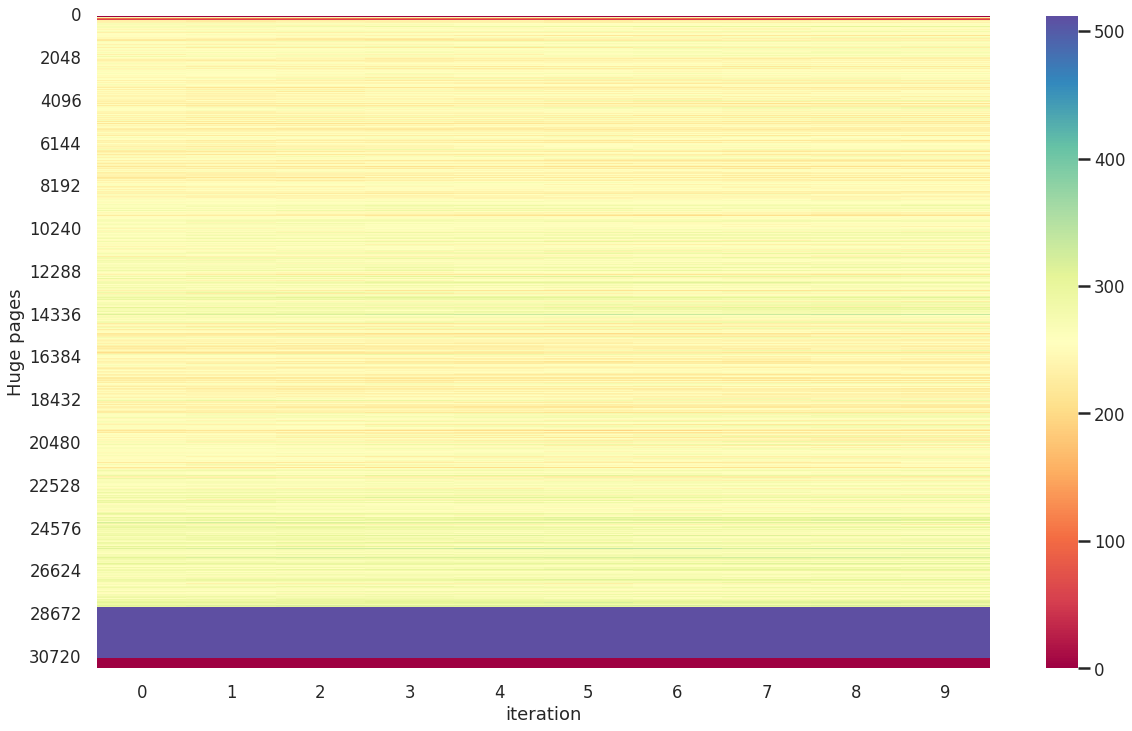

In [6]:
# Heatmap Array
fix, ax = plt.subplots()
fix.set_figwidth(20)
fix.set_figheight(12)
fix.set_facecolor("white")

cmap = cmap_extreme(sns.color_palette("Spectral", as_cmap=True, n_colors=10))

data = parse_fragout(Path("frag/frag.bin"), 10)
excerpt = data.T

plot = sns.heatmap(excerpt, ax=ax, cmap=cmap,
                   yticklabels=2*1024, xticklabels=1)
plot.set(ylabel="Huge pages")
plot.set(xlabel="iteration")


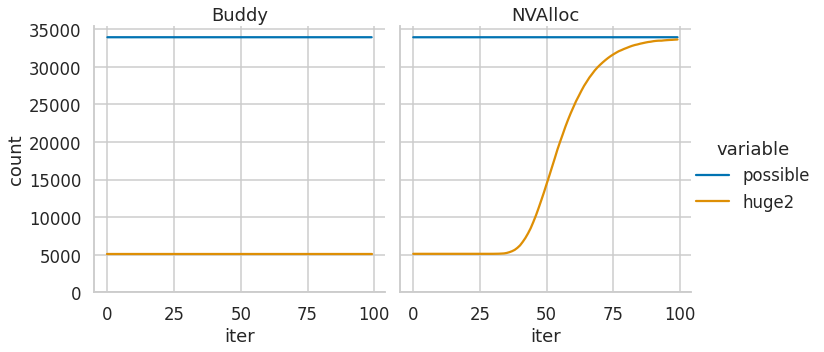

In [ ]:
bdata = pd.read_csv(buddy / "out.csv")
bdata["possible"] = bdata["small"] / 512
bdata["alloc"] = "Buddy"

ndata = pd.read_csv(nvalloc / "out.csv")
ndata["possible"] = ndata["small"] / 512
ndata["alloc"] = "NVAlloc"

data = pd.concat([bdata, ndata])
data = data.melt(["alloc", "iter"], value_vars=["possible", "huge2"], value_name="count")

plt = sns.relplot(data=data, kind="line", x="iter", y="count", hue="variable", col="alloc")
plt.set_titles("{col_name}")
plt.set(ylim=(0, None))
plt.savefig("frag.png", transparent=False, facecolor="white")

# TODO: Anzahl huge pages mit/ohne draining

[(0.0, 35368.71328125)]

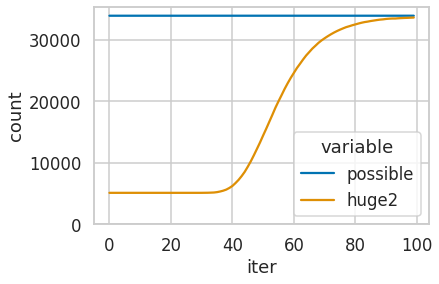

In [ ]:
data = pd.read_csv(nvalloc / "out.csv")
data["possible"] = data["small"] / 512

data = data[["iter", "possible", "huge2"]].melt(
    ["iter"], value_vars=["possible", "huge2"], value_name="count")

plt = sns.lineplot(data, x="iter", y="count", hue="variable")
plt.set(ylim=(0, None))


[(0.0, 35369.66572265625)]

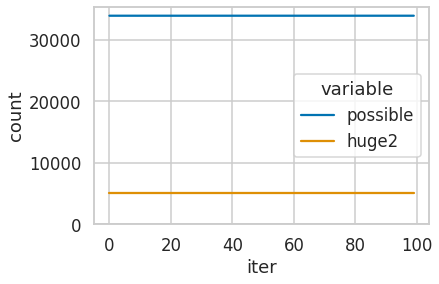

In [ ]:
data = pd.read_csv(buddy / "out.csv")
data["possible"] = data["small"] / 512

data = data[["iter", "possible", "huge2"]].melt(
    ["iter"], value_vars=["possible", "huge2"], value_name="count")

plt = sns.lineplot(data, x="iter", y="count", hue="variable")
plt.set(ylim=(0, None))
